In [1]:
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import statsmodels.api as sm

from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
from scipy import stats

In [2]:
INPUT_ZIP = "../data/in/Fraud_Detction_Dataset.zip"  # Directorio del zip
OUTPUT_FOLDER = "../data/out/"  # Directorio de destino
TRAIN_FILENAME = "creditcard.csv"  # Nombre del fichero de entrenamiento

def fetch_data(input_path=INPUT_ZIP, output_dir=OUTPUT_FOLDER):
    
    # Comprobación de que el directorio de destino existe
    os.makedirs(output_dir, exist_ok=True)

    # Descomprime el archivo ZIP en caso de que no haya ningún csv en la carpeta
    if(len([file for file in os.listdir(output_dir) if file.endswith('.csv')]) == 0):
        with zipfile.ZipFile(input_path, 'r') as zip_ref:
            zip_ref.extractall(output_dir)


def load_data(directory=OUTPUT_FOLDER, filename=TRAIN_FILENAME):

    # Construir la ruta completa al archivo CSV
    file_path = os.path.join(directory, filename)

    # Verificar si el archivo existe
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"El archivo {filename} no se encuentra en el directorio {directory}")

    # Leer el archivo CSV en un DataFrame
    return pd.read_csv(file_path)

fetch_data()
df = load_data()

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve



In [4]:
# Filtrar los datos eliminando los valores atípicos excepto para 'Class' igual a 1

Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df_cleaned = df[
    (df['Class'] == 1) | 
    ~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)
]

# Mostrar el nuevo DataFrame sin valores atípicos
df_cleaned

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284796,172780.0,1.884849,-0.143540,-0.999943,1.506772,-0.035300,-0.613638,0.190241,-0.249058,0.666458,...,0.144008,0.634646,-0.042114,-0.053206,0.316403,-0.461441,0.018265,-0.041068,60.00,0
284797,172782.0,-0.241923,0.712247,0.399806,-0.463406,0.244531,-1.343668,0.929369,-0.206210,0.106234,...,-0.228876,-0.514376,0.279598,0.371441,-0.559238,0.113144,0.131507,0.081265,5.49,0
284800,172784.0,2.039560,-0.175233,-1.196825,0.234580,-0.008713,-0.726571,0.017050,-0.118228,0.435402,...,-0.268048,-0.717211,0.297930,-0.359769,-0.315610,0.201114,-0.080826,-0.075071,2.68,0
284801,172785.0,0.120316,0.931005,-0.546012,-0.745097,1.130314,-0.235973,0.812722,0.115093,-0.204064,...,-0.314205,-0.808520,0.050343,0.102800,-0.435870,0.124079,0.217940,0.068803,2.69,0


Escalamos time y amount, ya que las demas variables ya han sido escaladas previamente al realizarse un pca previo

In [5]:
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
#escalamos time y amount ya que son las variables que no han sido escaladas
#previamente porque no se han sometido a un pca por lo que las escalamos ahora.
scaler = RobustScaler()
scaled_time_amount = scaler.fit_transform(df_cleaned[["Time", "Amount"]])
scaled_df = pd.DataFrame(scaled_time_amount, columns=["Time_scaled", "Amount_scaled"], index=df_cleaned.index)
final_df = pd.concat([df_cleaned.drop(columns=["Time", "Amount"]), scaled_df], axis=1)
final_df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,Time_scaled,Amount_scaled
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,-0.959390,2.910960
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.959390,-0.303435
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,-0.959378,2.339532
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.959366,1.168891
5,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,-0.371407,...,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,0,-0.959366,-0.281995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284796,1.884849,-0.143540,-0.999943,1.506772,-0.035300,-0.613638,0.190241,-0.249058,0.666458,0.120908,...,0.634646,-0.042114,-0.053206,0.316403,-0.461441,0.018265,-0.041068,0,1.069711,0.950339
284797,-0.241923,0.712247,0.399806,-0.463406,0.244531,-1.343668,0.929369,-0.206210,0.106234,-0.284708,...,-0.514376,0.279598,0.371441,-0.559238,0.113144,0.131507,0.081265,0,1.069735,-0.242179
284800,2.039560,-0.175233,-1.196825,0.234580,-0.008713,-0.726571,0.017050,-0.118228,0.435402,0.267772,...,-0.717211,0.297930,-0.359769,-0.315610,0.201114,-0.080826,-0.075071,0,1.069758,-0.303653
284801,0.120316,0.931005,-0.546012,-0.745097,1.130314,-0.235973,0.812722,0.115093,-0.204064,-0.657422,...,-0.808520,0.050343,0.102800,-0.435870,0.124079,0.217940,0.068803,0,1.069770,-0.303435


Dividimos los datos con stratify= y ya que el dataset esta muy desbalanceado y queremos mantener las proporciones en el df de prueba, validacion y entreneamiento

In [7]:
def crear_datasets (datos, porc_entrena, porc_prueba, porc_valida): 
  tamaño_prueba=(porc_prueba+porc_valida)/(porc_entrena+porc_prueba+porc_valida) 
  data_entrena, data_test = train_test_split(datos, test_size=tamaño_prueba,random_state=42,shuffle=True) 
  tamaño_prueba=porc_valida/(porc_prueba+porc_valida) 
  data_prueba, data_valida=train_test_split(data_test,test_size=tamaño_prueba,random_state=42,shuffle=True) 
  return data_entrena, data_prueba, data_valida 

In [9]:
df_entrena,df_pru,df_valida=crear_datasets(final_df,70,15,15) 
print(f"Dimensiones del dataset de entrenamiento: {df_entrena.shape}") 
print(f"Dimensiones del dataset de prueba: {df_pru.shape}") 
print(f"Dimensiones del dataset de validación: {df_valida.shape}") 

Dimensiones del dataset de entrenamiento: (102767, 31)
Dimensiones del dataset de prueba: (22022, 31)
Dimensiones del dataset de validación: (22022, 31)


In [10]:
X_entrena= df_entrena.drop("Class",axis=1) 
y_entrena=df_entrena["Class"].copy() 
X_pru= df_pru.drop("Class",axis=1) 
y_pru=df_pru["Class"].copy() 
X_valida= df_valida.drop("Class",axis=1) 
y_valida=df_valida["Class"].copy() 

### XGBCLASSIFIER

In [12]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb
from xgboost import XGBClassifier

# Set xgboost parameters
params = {
    'objective': 'binary:logistic',
    'eta': 0.039,  # Learning rate
    'verbosity': 0,  # No verbose output
    'max_depth': 5,  # Ajustable según el modelo
    'subsample': 0.8,  # Fraction of data for each tree
    'colsample_bytree': 0.9,  # Fraction of features for each tree
    'eval_metric': 'auc',  # Area Under the Curve
    'random_state': 42,  # For reproducibility
    'n_estimators': 100  # Número de árboles, ajustar según experimentación
}

# Create the XGBoost model
xgb_model = XGBClassifier(**params)

# Train the model
xgb_model.fit(X_entrena, y_entrena)





XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.039, eval_metric='auc',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
# Evaluar el modelo en entrenamiento
y_train_pred = xgb_model.predict(X_entrena)
y_train_pred_proba = xgb_model.predict_proba(X_entrena)[:, 1]

# AUC en entrenamiento
from sklearn.metrics import roc_auc_score
auc_train = roc_auc_score(y_entrena, y_train_pred_proba)
print(f"AUC en entrenamiento: {auc_train}")

# Reporte de clasificación en entrenamiento
from sklearn.metrics import classification_report
print("Reporte de clasificación en entrenamiento:")
print(classification_report(y_entrena, y_train_pred))


AUC en entrenamiento: 0.990330527053553
Reporte de clasificación en entrenamiento:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    102418
           1       1.00      0.93      0.97       349

    accuracy                           1.00    102767
   macro avg       1.00      0.97      0.98    102767
weighted avg       1.00      1.00      1.00    102767



In [13]:
# Predecir en el conjunto de prueba
y_pred_prueba = xgb_model.predict(X_pru)
y_proba_prueba = xgb_model.predict_proba(X_pru)[:, 1]

# Evaluación: AUC y otras métricas
from sklearn.metrics import roc_auc_score, classification_report

# AUC en el conjunto de prueba
auc_prueba = roc_auc_score(y_pru, y_proba_prueba)
print(f"AUC en prueba: {auc_prueba}")

# Reporte de clasificación (Precision, Recall, F1, etc.)
print("Reporte de clasificación en prueba:")
print(classification_report(y_pru, y_pred_prueba))


AUC en prueba: 0.9613691638611667
Reporte de clasificación en prueba:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21965
           1       1.00      0.86      0.92        57

    accuracy                           1.00     22022
   macro avg       1.00      0.93      0.96     22022
weighted avg       1.00      1.00      1.00     22022



In [14]:
# Predecir en el conjunto de validación
y_pred_valida = xgb_model.predict(X_valida)
y_proba_valida = xgb_model.predict_proba(X_valida)[:, 1]

# Evaluación: AUC y otras métricas
# AUC en el conjunto de validación
auc_valida = roc_auc_score(y_valida, y_proba_valida)
print(f"AUC en validación: {auc_valida}")

# Reporte de clasificación (Precision, Recall, F1, etc.)
print("Reporte de clasificación en validación:")
print(classification_report(y_valida, y_pred_valida))


AUC en validación: 0.9808025036893797
Reporte de clasificación en validación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21936
           1       1.00      0.87      0.93        86

    accuracy                           1.00     22022
   macro avg       1.00      0.94      0.97     22022
weighted avg       1.00      1.00      1.00     22022



### Optimizacion de hiperparametros

In [16]:
param_grid = {
    'max_depth': [6, 7, 9],  # Probar diferentes profundidades de los árboles
    'learning_rate': [0.05, 0.1],  # Diferentes tasas de aprendizaje
    'n_estimators': [50, 100, 150],  # Número de árboles a probar
    'subsample': [0.7, 0.8, 0.9],  # Fracción de datos para cada árbol
    'colsample_bytree': [0.8, 0.9],  # Fracción de características para cada árbol
    'min_child_weight': [1, 3, 5],  # Control de regularización
    'scale_pos_weight': [1, 5, 10]  # Ajustar para desbalance de clases
}

# Inicializar el modelo XGBoost
xgb_model_optimized = XGBClassifier(objective='binary:logistic', eval_metric='auc', random_state=42)

# Realizar Grid Search con validación cruzada
grid_search = GridSearchCV(estimator=xgb_model_optimized, param_grid=param_grid, 
                           scoring='roc_auc', cv=3, verbose=1, n_jobs=-1)

# Ajustar el modelo a los datos de entrenamiento
grid_search.fit(X_entrena, y_entrena)

# Mostrar los mejores parámetros encontrados
print("Mejores parámetros:", grid_search.best_params_)

# Ver el mejor resultado de la búsqueda
print("Mejor AUC en validación:", grid_search.best_score_)

Fitting 3 folds for each of 972 candidates, totalling 2916 fits
Mejores parámetros: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100, 'scale_pos_weight': 10, 'subsample': 0.9}
Mejor AUC en validación: 0.9950608197277844


In [20]:
# Evaluar el mejor modelo en el conjunto de prueba
best_model = grid_search.best_estimator_

# Predecir en el conjunto de prueba
y_pred_prueba = best_model.predict(X_pru)
y_proba_prueba = best_model.predict_proba(X_pru)[:, 1]

# AUC en el conjunto de prueba
auc_prueba = roc_auc_score(y_pru, y_proba_prueba)
print(f"AUC en prueba con el mejor modelo: {auc_prueba}")

# Reporte de clasificación (Precision, Recall, F1, etc.)
print("Reporte de clasificación en prueba con el mejor modelo:")
print(classification_report(y_pru, y_pred_prueba)) 

# Predecir en el conjunto de validación
y_pred_valida = best_model.predict(X_valida)
y_proba_valida = best_model.predict_proba(X_valida)[:, 1]

# AUC en el conjunto de validación
auc_valida = roc_auc_score(y_valida, y_proba_valida)
print(f"AUC en validación con el mejor modelo: {auc_valida}")

# Reporte de clasificación (Precision, Recall, F1, etc.)
print("Reporte de clasificación en validación con el mejor modelo:")
print(classification_report(y_valida, y_pred_valida))


AUC en prueba con el mejor modelo: 0.9859153917116944
Reporte de clasificación en prueba con el mejor modelo:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21965
           1       1.00      0.89      0.94        57

    accuracy                           1.00     22022
   macro avg       1.00      0.95      0.97     22022
weighted avg       1.00      1.00      1.00     22022

AUC en validación con el mejor modelo: 0.9907707198955099
Reporte de clasificación en validación con el mejor modelo:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21936
           1       1.00      0.92      0.96        86

    accuracy                           1.00     22022
   macro avg       1.00      0.96      0.98     22022
weighted avg       1.00      1.00      1.00     22022



### Feature importance

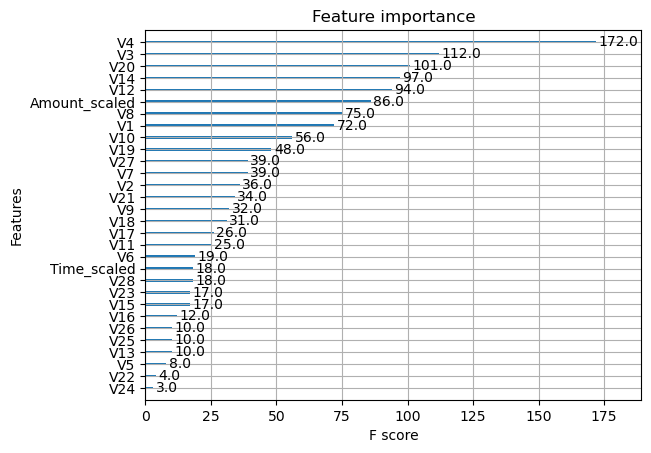

In [24]:
import matplotlib.pyplot as plt
xgb.plot_importance(xgb_model)
plt.show()

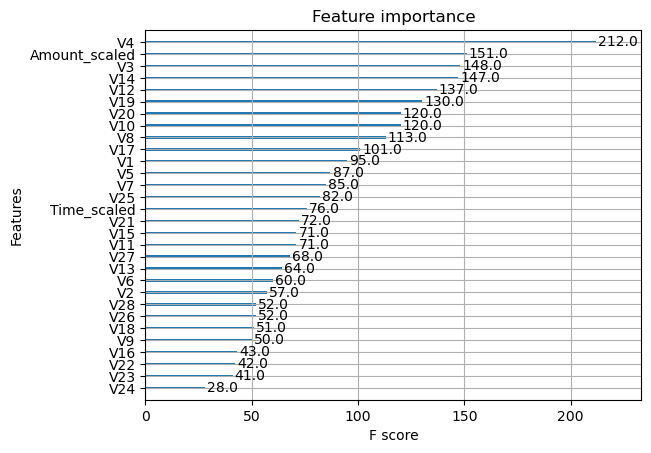

In [25]:
import matplotlib.pyplot as plt
xgb.plot_importance(best_model)
plt.show()

In [27]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(best_model, X_entrena, y_entrena, 
                         cv=5, scoring='roc_auc', n_jobs=-1)

print("AUC por fold:", scores)
print("AUC promedio:", scores.mean())

AUC por fold: [0.98211461 0.99993933 0.98907242 0.9956912  0.99167358]
AUC promedio: 0.9916982278789191
